## Librerias

In [1]:
library(dplyr)

library(FactoClass)
library(FactoMineR)
library(factoextra)
library(plotly)
library(knitr)
library(DT)
library(DBI)


Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Cargando paquete requerido: ade4

Cargando paquete requerido: ggplot2

Cargando paquete requerido: ggrepel

Cargando paquete requerido: xtable

Cargando paquete requerido: scatterplot3d


Adjuntando el paquete: 'FactoMineR'


The following object is masked from 'package:ade4':

    reconst


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Adjuntando el paquete: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout




## Parametros

In [18]:
# Proyecto de GCP
project <- "co-keralty-costomedico"

# Query para traer la data de diabetes
query <- "SELECT * FROM Diabetes_avicena_survival.diabetes_final"

# Configuracion de la conexion a BigQuery
con <- dbConnect(bigrquery::bigquery(),
                 project = project,
                 dataset = "Diabetes_avicena_survival",
                 location = "us-east1")

# Columnas cualitativas
variables_numericas <- c("year",
                         "month",
                         "edad",
                         "IMC",
                         "trigliceridos",
                         "perimetro_abdominal",
                         "time_to_event")

# Columnas categoricas
variables_factores <- c("genero_paciente",
                        "raza_paciente",
                        "nivel_academico_paciente",
                        "ant_cardio",
                        "med_hipertension",
                        "ant_familiar_dm",
                        "hace_ejercicio",
                        "diabetes")

# Columnas para el ACM
columns_for_acm <- c("genero_paciente",
                     "raza_paciente",
                     "nivel_academico_paciente",
                     "ant_cardio",
                     "med_hipertension",
                     # "tabaquismo",
                    #  "trastornos_suenno",
                    #  "enfermedad_renal",
                     # "ant_familiar_dm",
                     "hace_ejercicio",
                     "diabetes"
)

## Carga de datos

In [17]:
# Traer la data desde BigQuery
data <- read.table("datas_no_outliers.csv",
                   sep = "|", header = TRUE)
head(data)

,numero_identificacion_paciente,year,month,fecha,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
,<dbl>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>
1,26151819,2022,8,2022-08-01,70,32.44,45.3,158.0,238.0,96.0,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0,1
2,1007107070,2022,8,2022-08-01,19,21.60,56.0,99.0,95.0,75.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
3,34341427,2024,1,2024-01-01,39,30.47,64.5,102.0,162.1,89.5,Femenino,Otros,Tecnológica,0,0,0,40 minutos,0,1
4,94426911,2024,1,2024-01-01,50,29.71,38.0,150.8,211.0,95.0,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,0,1
5,43524938,2024,1,2024-01-01,56,23.31,51.0,143.4,254.7,74.5,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,0,1
6,7176822,2023,5,2023-05-01,44,30.56,45.5,151.8,90.1,101.5,Masculino,Otros,Básica secundaria,0,0,0,Nunca,0,1


In [19]:
# Realizar cambios en cada una de las columnas de la data
data <- data %>% mutate(across(all_of(variables_factores), as.factor))
data <- data %>% mutate(across(all_of(variables_numericas), as.numeric))

# Vista de los cambios realizados
str(data)

'data.frame':	8024 obs. of  19 variables:
 $ numero_identificacion_paciente: num  2.62e+07 1.01e+09 3.43e+07 9.44e+07 4.35e+07 ...
 $ year                          : num  2022 2022 2024 2024 2024 ...
 $ month                         : num  8 8 1 1 1 5 5 9 2 2 ...
 $ fecha                         : chr  "2022-08-01" "2022-08-01" "2024-01-01" "2024-01-01" ...
 $ edad                          : num  70 19 39 50 56 44 45 43 31 55 ...
 $ IMC                           : num  32.4 21.6 30.5 29.7 23.3 ...
 $ HDL                           : num  45.3 56 64.5 38 51 45.5 46 30 33.4 26 ...
 $ LDL                           : num  158 99 102 151 143 ...
 $ trigliceridos                 : num  238 95 162 211 255 ...
 $ perimetro_abdominal           : num  96 75 89.5 95 74.5 ...
 $ genero_paciente               : Factor w/ 2 levels "Femenino","Masculino": 1 1 1 2 1 2 2 1 1 2 ...
 $ raza_paciente                 : Factor w/ 7 levels "Afrocolombiano",..: 3 4 4 3 4 4 4 4 4 4 ...
 $ nivel_academico_pacien

## ACP

In [16]:
vars_ilustrativas <- c()

In [27]:
data_to_acp <- data[, 5:10]
head(data_to_acp)

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,70,32.44,45.3,158.0,238.0,96.0
2,19,21.60,56.0,99.0,95.0,75.0
3,39,30.47,64.5,102.0,162.1,89.5
4,50,29.71,38.0,150.8,211.0,95.0
5,56,23.31,51.0,143.4,254.7,74.5
6,44,30.56,45.5,151.8,90.1,101.5


In [28]:
acp <- dudi.pca(data_to_acp, scannf = FALSE, nf = 6)

[1] "Medias de las variables"
               edad                 IMC                 HDL                 LDL 
           59.03103            28.09459            47.75025           111.85482 
      trigliceridos perimetro_abdominal 
          143.12843            93.27355 
[1] "Desviacion estandar de las variables"
               edad                 IMC                 HDL                 LDL 
              15.21                4.53               10.90               36.99 
      trigliceridos perimetro_abdominal 
              58.81               11.43 
[1] "Valores propios"


Inertia information:
Call: inertia.dudi(x = acp)

Decomposition of total inertia:
    inertia     cum  cum(%)
Ax1  2.0059   2.006   33.43
Ax2  1.1702   3.176   52.93
Ax3  1.0955   4.271   71.19
Ax4  0.9360   5.208   86.79
Ax5  0.5334   5.741   95.68
Ax6  0.2590   6.000  100.00

[1] "Vectores Propios"
                       CS1    CS2    CS3   CS4    CS5    CS6
edad                -0.129  0.558 -0.364 0.675  0.174 -0.230
IMC                  0.574  0.097  0.425 0.058 -0.121 -0.680
HDL                 -0.419  0.074  0.532 0.352 -0.629  0.130
LDL                  0.008 -0.705  0.169 0.576  0.377 -0.006
trigliceridos        0.385 -0.300 -0.558 0.206 -0.635  0.064
perimetro_abdominal  0.574  0.294  0.254 0.204  0.121  0.681
[1] "Histograma de los valores propios"


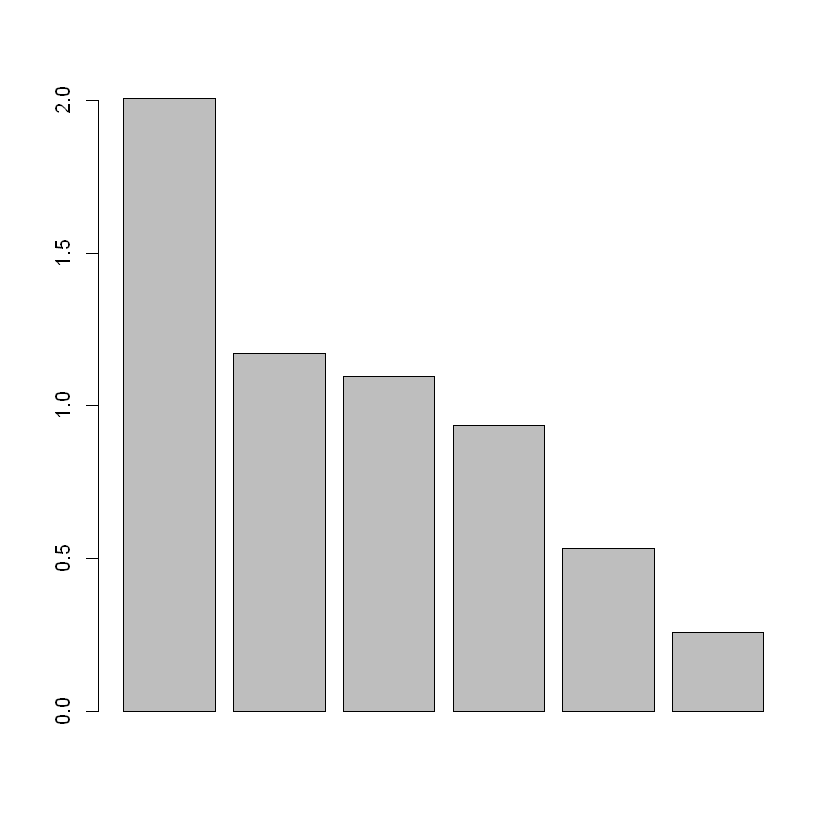

In [29]:
print("Medias de las variables")
print(acp$cent)

print("Desviacion estandar de las variables")
print(round(acp$norm, 2))

print("Valores propios")
inertia(acp)

print("Vectores Propios")
print(round(acp$c1, 3))

print("Histograma de los valores propios")
barplot(acp$eig)

[1] "Histograma del porcentaje de variacion"


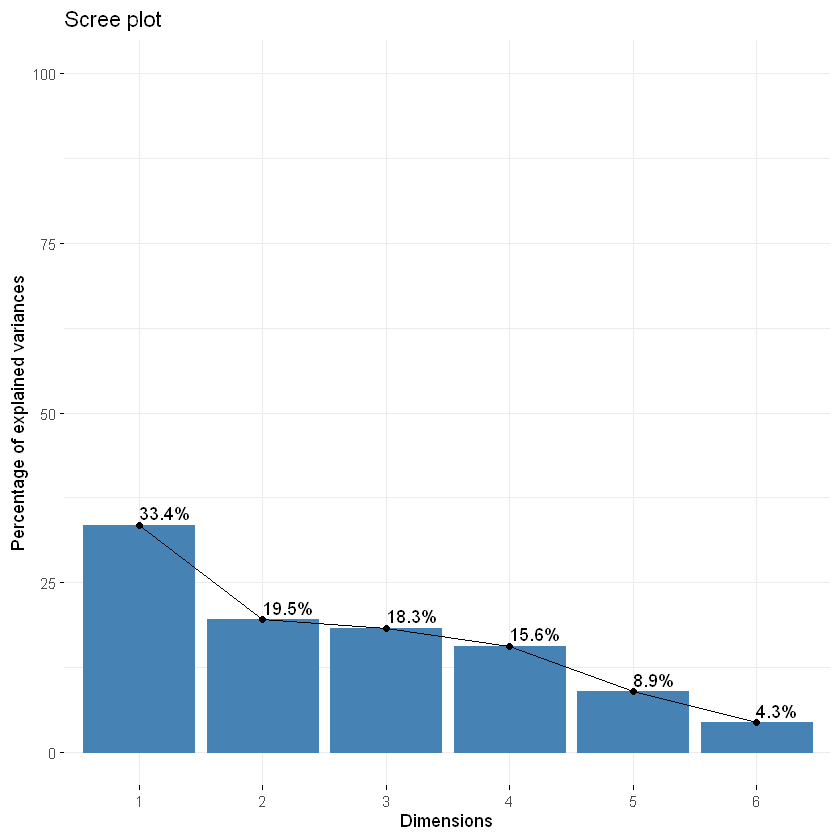

In [30]:
print("Histograma del porcentaje de variacion")
fviz_screeplot(acp, addlabels = TRUE, ylim = c(0, 100))

In [31]:
print("Entendimiento de los valores")
inertia(acp, , TRUE)

[1] "Entendimiento de los valores"


Inertia information:
Call: inertia.dudi(x = acp, col.inertia = TRUE)

Decomposition of total inertia:
    inertia     cum  cum(%)
Ax1  2.0059   2.006   33.43
Ax2  1.1702   3.176   52.93
Ax3  1.0955   4.271   71.19
Ax4  0.9360   5.208   86.79
Ax5  0.5334   5.741   95.68
Ax6  0.2590   6.000  100.00

Column contributions (%):
               edad                 IMC                 HDL                 LDL 
              16.67               16.67               16.67               16.67 
      trigliceridos perimetro_abdominal 
              16.67               16.67 

Column absolute contributions (%):
                        Axis1   Axis2   Axis3   Axis4   Axis5     Axis6
edad                 1.667871 31.1483  13.255 45.6173   3.034  5.277777
IMC                 32.935226  0.9410  18.027  0.3377   1.456 46.302929
HDL                 17.587434  0.5419  28.278 12.3894  39.511  1.693094
LDL                  0.006719 49.7309   2.858 33.2222  14.179  0.003225
trigliceridos       14.808720  9.01

[1] "Correlaciones de las variables suplementarias"


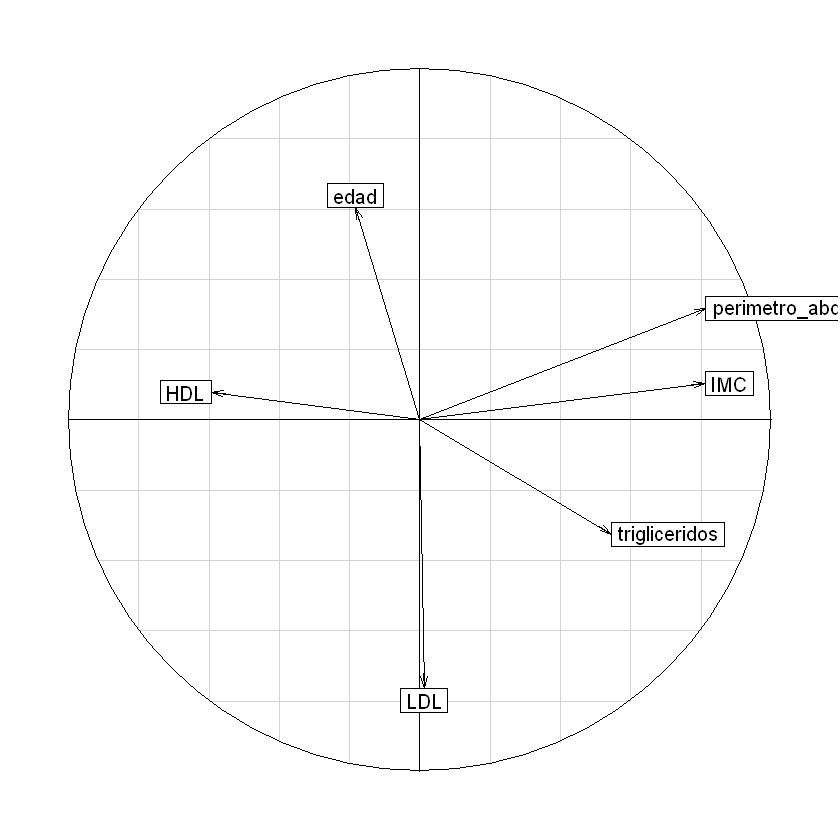

In [32]:
print("Correlaciones de las variables suplementarias")
s.corcircle(acp$co, xax = 1, yax = 2)

[1] "Correlaciones de las variables suplementarias"


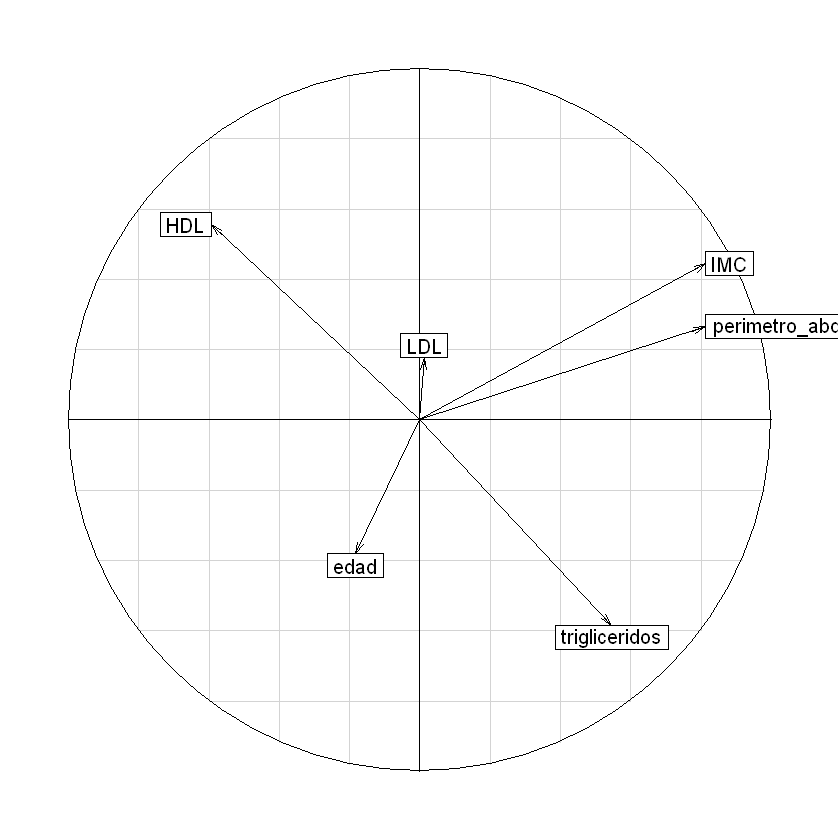

In [33]:
print("Correlaciones de las variables suplementarias")
s.corcircle(acp$co, xax = 1, yax = 3)

In [34]:
sup <- supqual(acp, data[, c("diabetes")])

kable(cbind(wcat = sup$wcat, d2 = sup$dis2, sup$coor), digits = 3)



|   |  wcat|    d2|  Axis1|  Axis2|  Axis3|  Axis4|  Axis5|  Axis6|
|:--|-----:|-----:|------:|------:|------:|------:|------:|------:|
|X0 | 0.834| 0.003| -0.046| -0.018|  0.020|  0.001|  0.008|  0.005|
|X1 | 0.166| 0.075|  0.232|  0.092| -0.101| -0.004| -0.041| -0.024|

[1] "Representacion de Diabetes en los ejes principales"


        Axis2       Axis3
0 -0.01841740  0.02007061
1  0.09228013 -0.10056352


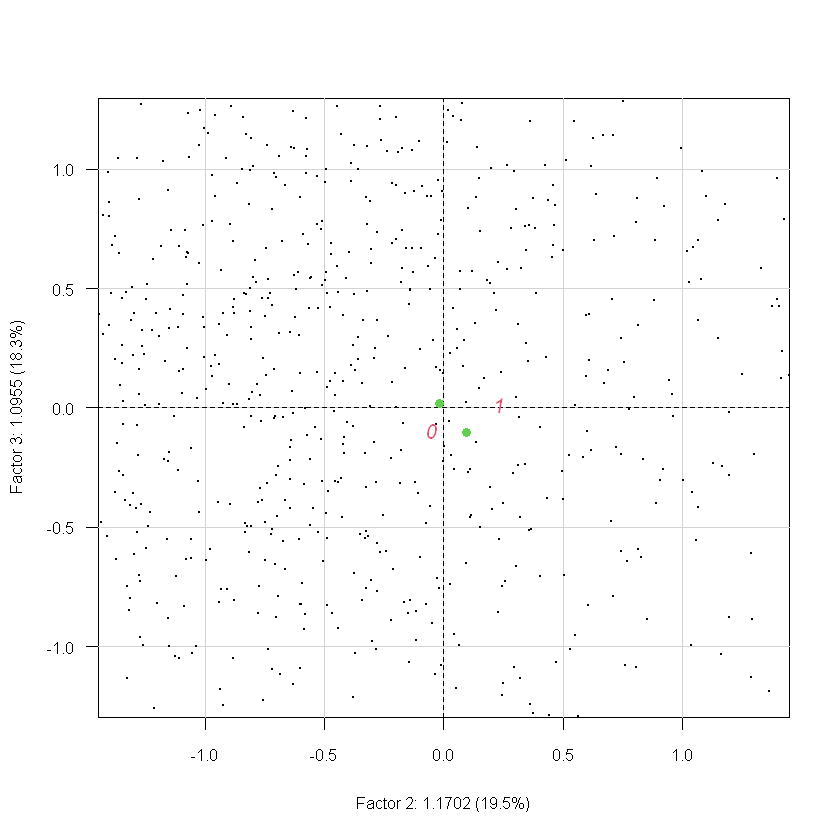

In [35]:
print("Representacion de Diabetes en los ejes principales")
ejes <- c(2, 3)
plot(acp[1:1000, ], ex = ejes[1], ey = ejes[2],
     Tcol = FALSE, ucal = 100, cex.row = 0.01,
     ylim = c(-1, 1), xlim = c(-1, 1))
print(sup$coor[, ejes])
points(sup$coor[, ejes], col = 3, pch = 16)
text(sup$coor, labels = rownames(sup$coor),
     col = 2, pos = 1, font = 3)

[1] "Agrupamiento basado en Diabetes para los ejes principales 2 y 3"


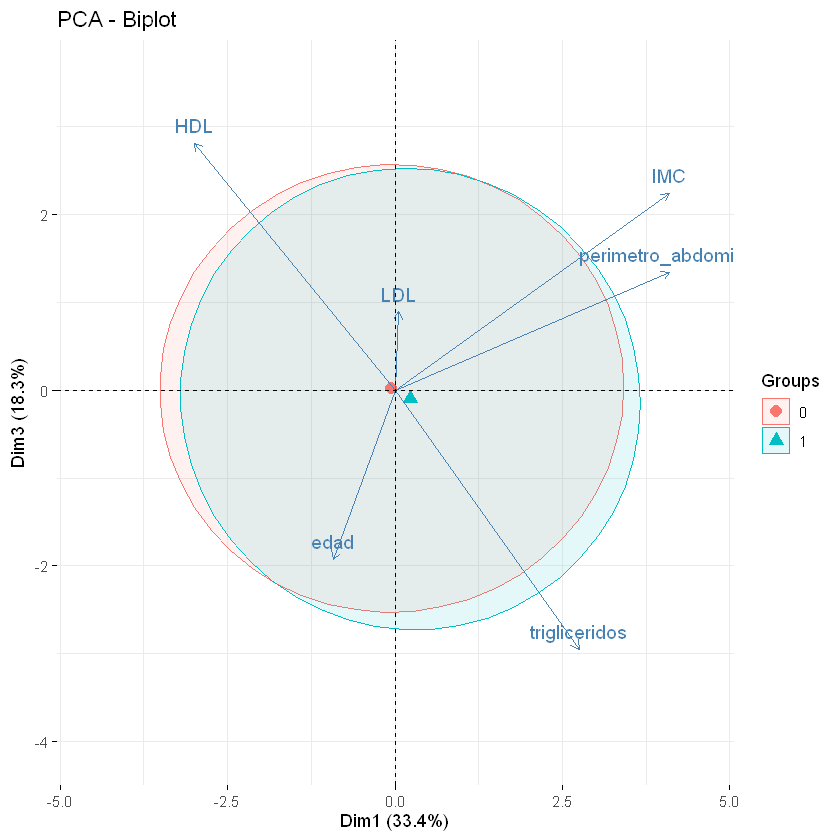

In [36]:
print("Agrupamiento basado en Diabetes para los ejes principales 2 y 3")
fviz_pca_biplot(acp, axes = c(1, 3), label = "var",
                habillage = data$diabetes,
                alpha.ind = 0,
                col.circle = "green",
                addEllipses = TRUE)

## ACM

In [41]:
head(data,1)

,numero_identificacion_paciente,year,month,fecha,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,26151819,2022,8,2022-08-01,70,32.44,45.3,158,238,96,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0,1


In [40]:
data_to_var_sup <- data[, c(2, 3, 5, 6, 7, 8, 9, 10)]

head(data_to_var_sup)

,year,month,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022,8,70,32.44,45.3,158.0,238.0,96.0
2,2022,8,19,21.60,56.0,99.0,95.0,75.0
3,2024,1,39,30.47,64.5,102.0,162.1,89.5
4,2024,1,50,29.71,38.0,150.8,211.0,95.0
5,2024,1,56,23.31,51.0,143.4,254.7,74.5
6,2023,5,44,30.56,45.5,151.8,90.1,101.5


In [48]:
data_to_acm <- data[, columns_for_acm]


data_to_acm <- data_to_acm %>%
  mutate(nivel_academico_paciente = case_when(
    nivel_academico_paciente == "Básica primaria" ~ "Educación Básica",
    nivel_academico_paciente == "Básica secundaria" ~ "Educación Básica",
    nivel_academico_paciente == "Preescolar" ~ "Educación Básica",

    nivel_academico_paciente == "Bachillerato técnico" ~ "Educación Media",
    nivel_academico_paciente == "Media académica o clásica" ~ "Educación Media",
    nivel_academico_paciente == "Normalista" ~ "Educación Media",

    nivel_academico_paciente == "Técnica profesional" ~ "Educación Superior No Graduada",
    nivel_academico_paciente == "Tecnológica" ~ "Educación Superior No Graduada",

    nivel_academico_paciente == "Especialización" ~ "Educación Superior Graduada",
    nivel_academico_paciente == "Maestría" ~ "Educación Superior Graduada",
    nivel_academico_paciente == "Doctorado" ~ "Educación Superior Graduada",
    nivel_academico_paciente == "Profesional" ~ "Educación Superior Graduada",


    TRUE ~ nivel_academico_paciente
  ))


data_to_acm <- data_to_acm %>%
  mutate(raza_paciente = case_when(
    raza_paciente == "Afrocolombiano" ~ "Si",
    raza_paciente == "Palenquero" ~ "Si",
    raza_paciente == "Raizales" ~ "Si",
    raza_paciente == "Indígena" ~ "Si",
    raza_paciente == "Mestizo" ~ "Si",
    raza_paciente == "Rom/Gitano" ~ "Si",

    TRUE ~ raza_paciente
  ))


data_to_acm <- data_to_acm %>%
  mutate(hace_ejercicio = case_when(
    hace_ejercicio == "20 minutos\n" ~ "20",
    hace_ejercicio == "40 minutos\n" ~ "40",
    hace_ejercicio == "60 minutos\n" ~ "60",

    TRUE ~ "Nunca"))

head(data_to_acm)

,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,hace_ejercicio,diabetes
,<fct>,<chr>,<chr>,<fct>,<fct>,<chr>,<fct>
1,Femenino,Si,Educación Media,1,0,Nunca,0
2,Femenino,Otros,Educación Básica,0,0,Nunca,1
3,Femenino,Otros,Educación Superior No Graduada,0,0,Nunca,0
4,Masculino,Si,Educación Básica,0,0,Nunca,0
5,Femenino,Otros,Educación Superior No Graduada,0,0,Nunca,0
6,Masculino,Otros,Educación Básica,0,0,Nunca,0


In [49]:
data_to_acm <- cbind(data_to_acm, data_to_var_sup)

In [43]:
print(kable(table(data_to_acm[, c("nivel_academico_paciente", "diabetes")])))
print(kable(table(data_to_acm[, c("raza_paciente", "diabetes")])))



|                               |    0|   1|
|:------------------------------|----:|---:|
|Educación Básica               | 2842| 577|
|Educación Media                | 1046| 231|
|Educación Superior Graduada    |  905| 150|
|Educación Superior No Graduada |  544|  95|
|Ninguno                        | 1352| 282|


|      |    0|    1|
|:-----|----:|----:|
|Otros | 6261| 1262|
|Si    |  428|   73|


In [54]:
head(data_to_acm[, c(8, 9, 10, 11, 12, 13, 14, 15)])

,year,month,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022,8,70,32.44,45.3,158.0,238.0,96.0
2,2022,8,19,21.60,56.0,99.0,95.0,75.0
3,2024,1,39,30.47,64.5,102.0,162.1,89.5
4,2024,1,50,29.71,38.0,150.8,211.0,95.0
5,2024,1,56,23.31,51.0,143.4,254.7,74.5
6,2023,5,44,30.56,45.5,151.8,90.1,101.5


In [56]:
acm <- MCA(data_to_acm, graph = FALSE,
           quanti.sup = c(8, 9, 10, 11, 12, 13, 14, 15))

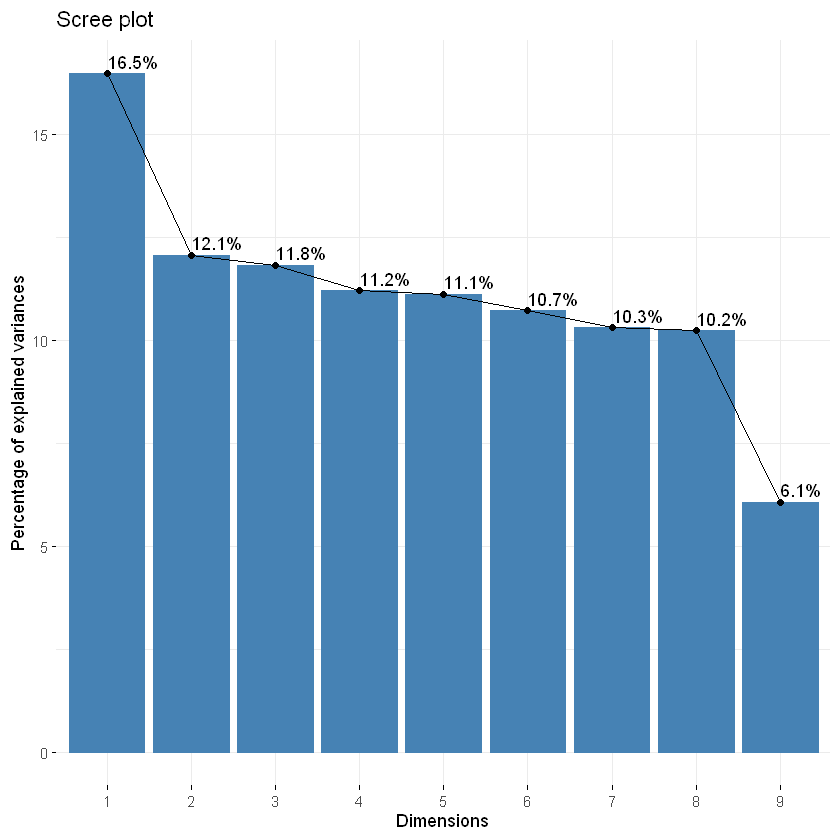

In [58]:
fviz_screeplot(acm, addlabels = TRUE)

In [60]:
crit_benzecri <- function(Y,acm) {
  s <- ncol(Y)
  l <- acm$eig[acm$eig[, 1] > 1 / s, 1]
  tau <- (s / (s - 1))^2 * (l - (1 / s))^2
  ptau <- tau / sum(tau) * 100
  barplot(ptau, col = "darkred", ylim = c(0, 75))
}

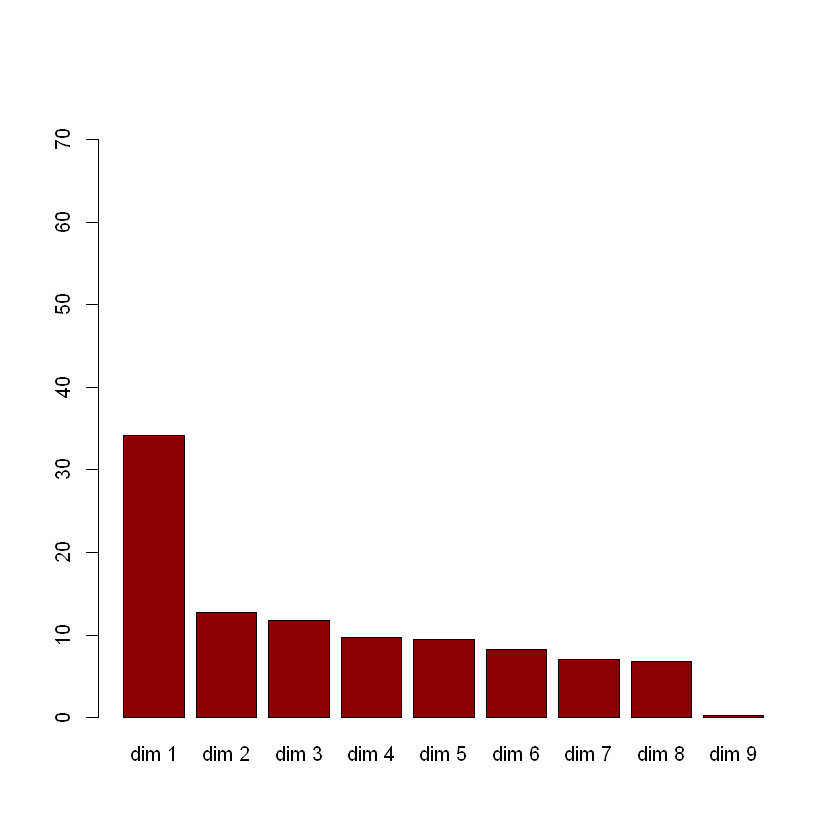

In [61]:
crit_benzecri(data_to_acm, acm)

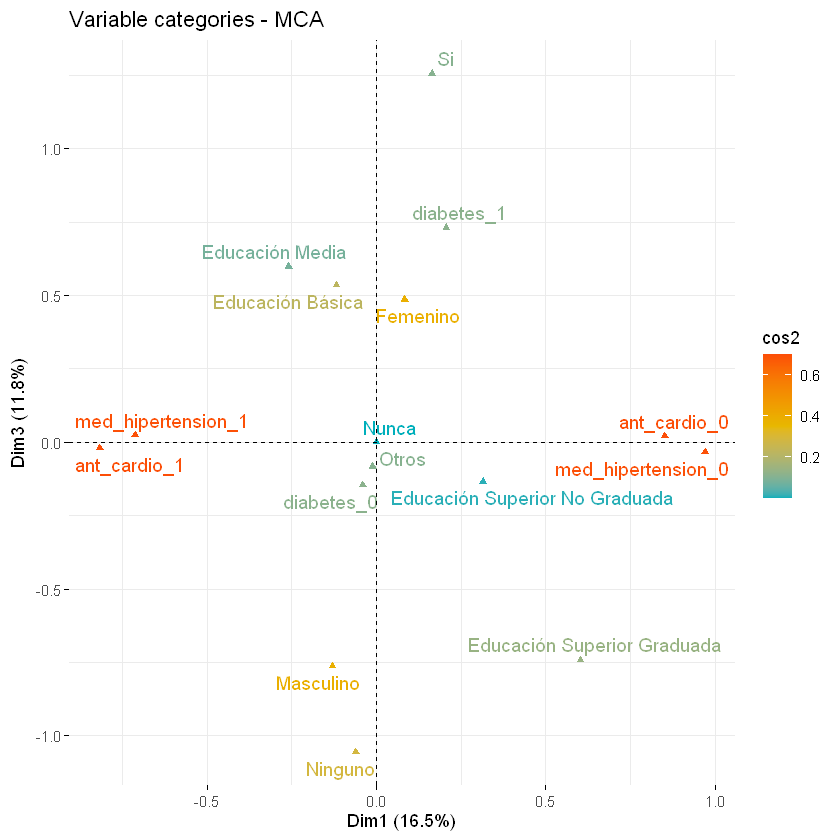

In [62]:
fviz_mca_var(acm, axes = c(1, 3), col.var = "cos2", repel = TRUE,
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             ggtheme = theme_minimal())

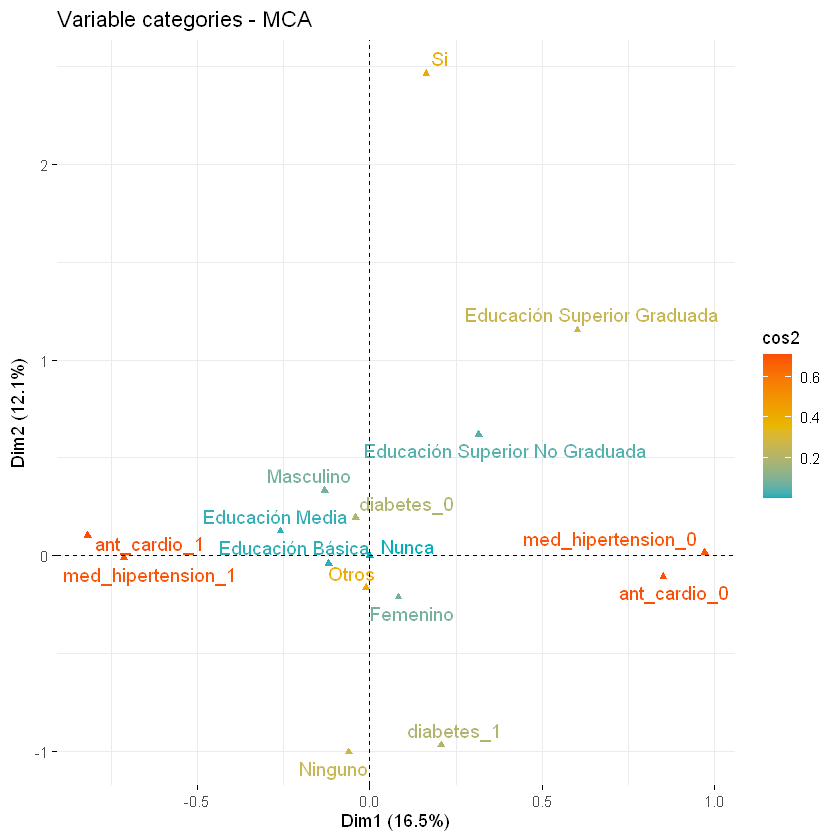

In [63]:
fviz_mca_var(acm, axes = c(1, 2), col.var = "cos2", repel = TRUE,
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             ggtheme = theme_minimal())

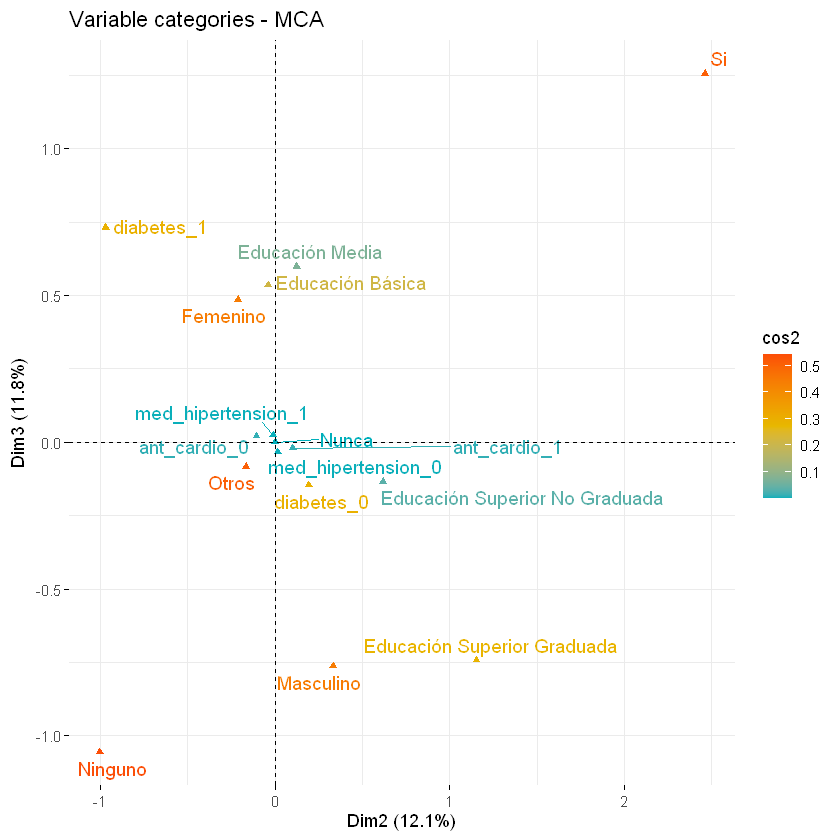

: 

In [64]:
fviz_mca_var(acm, axes = c(2, 3), col.var = "cos2", repel = TRUE,
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             ggtheme = theme_minimal())